<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

## Regression and Classification with the Ames Housing Data

## Modelling - Part 3

In [295]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import useful_functions
import scikitplot as skplt

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [73]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, make_scorer, f1_score, fbeta_score, plot_confusion_matrix, classification_report

In [236]:
# Load the data
df = pd.read_csv('housing_clean.csv')
df.shape

(1442, 80)

In [237]:
# convert MoSold and MSSubClass to strings to be used as categorical variables
df.MoSold = df.MoSold.astype(str)
df.MSSubClass = df.MSSubClass.astype(str)

In [238]:
# define lists of fixed features and renovateable features
fixed_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
                  'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
                  'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                  'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'Foundation', 
                  'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                  'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                  'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageCars', 
                  'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                  '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal']

renovateable_features = ['Utilities', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
                         'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond',
                         'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
                         'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                         'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

len(fixed_features), len(renovateable_features)

(50, 24)

In [239]:
df.SaleCondition.value_counts()

Normal     1190
Partial     122
Abnorml      96
Family       20
Alloca       10
AdjLand       4
Name: SaleCondition, dtype: int64

In [240]:
# since we are only interested in abnormal sales, classify SaleCondition as either Abnormal or Normal
df_3 = df.copy()
df_3.SaleCondition = df_3.SaleCondition.map(lambda x: 'Abnormal' if x == 'Abnorml' else 'Normal')

In [241]:
# calculate baseline accuracy
baseline = df_3.SaleCondition.value_counts(normalize=True).max()
print("Baseline accuracy: ", round(baseline, 4))

Baseline accuracy:  0.9334


In [242]:
# dummify categorical variables including NaN as a category
y_3 = df_3.SaleCondition
X_3 = pd.get_dummies(df_3[fixed_features + renovateable_features], dummy_na=True, drop_first=True)
X_3.shape

(1442, 283)

In [16]:
# get train-test split
# use stratify=y to maintain class split in train and test data
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, stratify=y_3, test_size=0.2, random_state=1)
X_3_train.shape, X_3_test.shape, y_3_train.shape, y_3_test.shape

((1153, 283), (289, 283), (1153,), (289,))

In [17]:
# standardize the data
scaler = StandardScaler()
X_3_train = pd.DataFrame(scaler.fit_transform(X_3_train), columns=X_3_train.columns)
X_3_test = pd.DataFrame(scaler.transform(X_3_test), columns=X_3_test.columns)

### Logistic Regression

In [59]:
log_reg = LogisticRegression(max_iter=100000)

gs_params = {'penalty': ['l1', 'l2'],
             'solver': ['saga'],
             'class_weight': [None, 'balanced'],
             'fit_intercept': [True, False],
             'C': np.logspace(-5, 1, 10)}

log_reg_gridsearch = GridSearchCV(log_reg,
                                  gs_params,
                                  n_jobs=-2, 
                                  cv=5, 
                                  verbose=3)

In [40]:
best_log_reg_scores = useful_functions.gridsearch_model_fitter(log_reg_gridsearch,
                                                               X_3_train, y_3_train, X_3_test, y_3_test)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 254 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:  4.9min finished


Best parameters:  {'C': 0.1, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Best estimator mean cross-validated training score:  0.9340899680030115
Best estimator score on the training set:  0.9375542064180399
Best estimator score on the test set:  0.9342560553633218


In [41]:
best_log_reg = log_reg_gridsearch.best_estimator_

In [42]:
print('Percent of predictions == Normal: ', np.sum(best_log_reg.predict(X_3_test) == 'Normal')/X_3_test.shape[0])

Percent of predictions == Normal:  1.0


### Comment
The best model found by GridSearchCV above selects 'Normal' 100% of the time on the test data. It does not predict a single instance of 'Abnormal'. This is a common problem with imbalanced datasets such as we have here i.e. the instances of 'Normal' outnumber the instances of 'Abnormal' in the dataset by a large proportion (93% 'Normal').  

The first GridSearchCV was run to maximize the accuracy score which appears high at 0.934 but this is effectively the baseline score as the model selects the majority class ('Normal') every time. We need to use different metrics to evaluate our model because of the imbalanced dataset.   

The balanced accuracy score is the average of recall obtained on each class. Maximizing the balanced accuracy score instead of the accuracy score should penalize putting too much relative effort on correctly predicting only one of the two possible classes, which can help with imbalanced datasets. Let's also try maximizing the F2 score for 'Abnormal' (F2 will put more weight on recall over precision as false negatives are more costly than false positives in this question). Next steps: run two more GridSearchCV, one to maximize the balanced accuracy score and one to maximize the F2 score.

**Note**   
We could run a KNN classification model to try to predict the 'Abnormal' sales but KNN models have no model coefficients so would not help us to identify the features that predict 'Abnormal' sales.

In [60]:
# create a gridsearch object to maximize the balanced accuracy score
log_reg_gridsearch_2 = GridSearchCV(log_reg,
                                    gs_params,
                                    scoring='balanced_accuracy',
                                    n_jobs=-2, 
                                    cv=5, 
                                    verbose=3)

In [61]:
best_log_reg_2_scores = useful_functions.gridsearch_model_fitter(log_reg_gridsearch_2, 
                                                                 X_3_train, y_3_train, X_3_test, y_3_test)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 254 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed: 16.7min finished


Best parameters:  {'C': 0.00021544346900318823, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'saga'}
Best estimator mean cross-validated training score:  0.6131276916451335
Best estimator score on the training set:  0.6813716023753198
Best estimator score on the test set:  0.5468810916179337


In [62]:
best_log_reg_2 = log_reg_gridsearch_2.best_estimator_

In [63]:
print('Percent of predictions == Normal: ', np.sum(best_log_reg_2.predict(X_3_test) == 'Normal')/X_3_test.shape[0])

Percent of predictions == Normal:  0.5086505190311419


In [67]:
# create a gridsearch object to maximize the F2 score
f1_scorer = make_scorer(f1_score, pos_label='Abnormal')
fbeta_scorer = make_scorer(fbeta_score, pos_label='Abnormal', beta=2)
log_reg_gridsearch_3 = GridSearchCV(log_reg,
                                    gs_params,
                                    scoring=fbeta_scorer,
                                    n_jobs=-2, 
                                    cv=5, 
                                    verbose=3)

In [68]:
best_log_reg_3_scores = useful_functions.gridsearch_model_fitter(log_reg_gridsearch_3, 
                                                                 X_3_train, y_3_train, X_3_test, y_3_test)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 251 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed: 17.1min finished


Best parameters:  {'C': 0.00021544346900318823, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'saga'}
Best estimator mean cross-validated training score:  0.30846496351152997
Best estimator score on the training set:  0.3619909502262444
Best estimator score on the test set:  0.25943396226415094


/Users/julia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [70]:
best_log_reg_3 = log_reg_gridsearch_3.best_estimator_

In [71]:
print('Percent of predictions == Normal: ', np.sum(best_log_reg_3.predict(X_3_test) == 'Normal')/X_3_test.shape[0])

Percent of predictions == Normal:  0.5294117647058824


### Confusion matrix

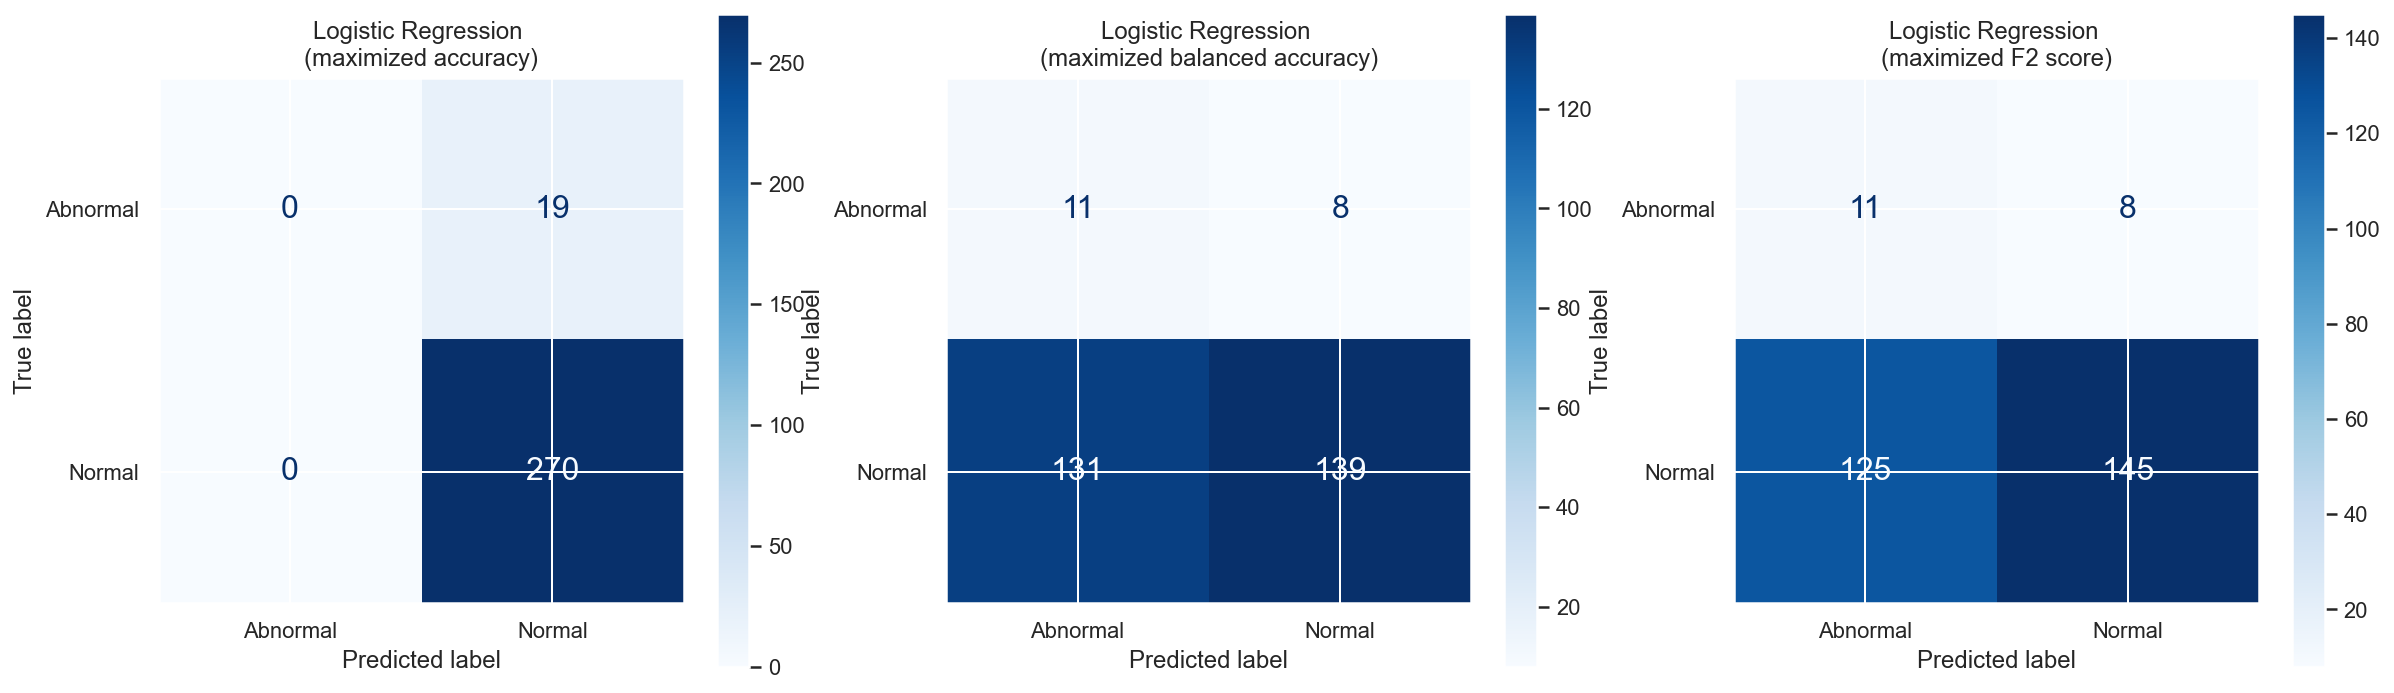

In [293]:
fig, ax = plt.subplots(ncols=3, figsize=(20,6))
plot_confusion_matrix(best_log_reg, X_3_test, y_3_test, cmap='Blues', ax=ax[0])
plot_confusion_matrix(best_log_reg_2, X_3_test, y_3_test, cmap='Blues', ax=ax[1])
plot_confusion_matrix(best_log_reg_3, X_3_test, y_3_test, cmap='Blues', ax=ax[2])
ax[0].set_title('Logistic Regression \n(maximized accuracy)')
ax[1].set_title('Logistic Regression \n(maximized balanced accuracy)')
ax[2].set_title('Logistic Regression \n(maximized F2 score)')
for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)
plt.show()

### Comment
The confusion matrices above show the results for the three logistic regression models on the test data, the first with the accuracy score maximized, the second with the balanced accuracy score maximized and the third with the F2 score maximized. As already discussed, the first always predicts 'Normal' so although the accuracy appears high it is useless for our purposes if it cannot identify any 'Abnormal' instances.

The second model in contrast does predict some instances of 'Abnormal'. It predicts 11 'Abnormal' instances out of 19 correctly but has a high number of false positives - it predicts 131 instances of 'Abnormal' which should be 'Normal'. 

The third model also predicts 11 'Abnormal' instances correctly, but with slightly fewer false positives (125).

In this question, we are more interested in minimizing false negatives than false positives i.e. we would rather identify correctly more 'Abnormal' instances at the expense of more false positives. Predictions of 'Abnormal' could be tested further by the bank which should have data on mortgages on the houses which could be used to reduce the false positives. Therefore we are more interested in a higher recall score than precision (which is also why I looked at the F2 score above, rather than F1). These scores are shown in the classification reports below.

### Classification report

In [86]:
predictions_log_reg = best_log_reg.predict(X_3_test)
predictions_log_reg_2 = best_log_reg_2.predict(X_3_test)
predictions_log_reg_3 = best_log_reg_3.predict(X_3_test)
probs_log_reg = best_log_reg.predict_proba(X_3_test)
probs_log_reg_2 = best_log_reg_2.predict_proba(X_3_test)
probs_log_reg_3 = best_log_reg_3.predict_proba(X_3_test)

In [87]:
print('Classification report for Logistic Regression model (maximized balanced accuracy)')
print(classification_report(y_3_test, predictions_log_reg_2, digits=4))

Classification report for Logistic Regression model (maximized balanced accuracy)
              precision    recall  f1-score   support

    Abnormal     0.0775    0.5789    0.1366        19
      Normal     0.9456    0.5148    0.6667       270

    accuracy                         0.5190       289
   macro avg     0.5115    0.5469    0.4017       289
weighted avg     0.8885    0.5190    0.6318       289



In [88]:
print('Classification report for Logistic Regression model (maximized F2 score)')
print(classification_report(y_3_test, predictions_log_reg_3, digits=4))

Classification report for Logistic Regression model (maximized F2 score)
              precision    recall  f1-score   support

    Abnormal     0.0809    0.5789    0.1419        19
      Normal     0.9477    0.5370    0.6856       270

    accuracy                         0.5398       289
   macro avg     0.5143    0.5580    0.4138       289
weighted avg     0.8907    0.5398    0.6498       289



### Comment
Changing the GridSearchCV to maximize the balanced accuracy or the F2 score instead of the accuracy does force the model to predict some instances of 'Abnormal' but there are still many false positives and false negatives.

Next steps: try looking at over-sampling using SMOTE. This technique generates synthetic data for the minority class ('Abnormal' in this case) using k nearest neighbours, to make the data balanced. Balancing the data can give better classification models.

### SMOTE

In [243]:
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [244]:
# get train-test split
# use stratify=y for stratification
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_3, y_3, stratify=y_3, test_size=0.2, random_state=1)
X_sm_train.shape, X_sm_test.shape, y_sm_train.shape, y_sm_test.shape

((1153, 283), (289, 283), (1153,), (289,))

In [245]:
X_sm_train.iloc[:2, 30:]

,OverallQual,OverallCond,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,GarageCond_Po,GarageCond_TA,GarageCond_nan,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_nan
1157,7,5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1371,6,6,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1


In [246]:
# create imblearn pipeline
pipe_sm = Pipeline([('scaler', StandardScaler()),
                    ('over-sampling', SMOTENC(categorical_features=range(32,283), random_state=2)),
                    ('model', LogisticRegression(max_iter=100000))])  

### Logistic Regression with SMOTE

In [272]:
gs_sm_params = {'model__penalty': ['l1', 'l2'],
                'model__solver': ['saga'],
                'model__class_weight': [None, 'balanced'],
                'model__fit_intercept': [True, False],
                'model__C': np.logspace(-5, 1, 10)}

log_reg_sm_gridsearch = GridSearchCV(pipe_sm,
                                     gs_sm_params,
                                     scoring='roc_auc',
                                     n_jobs=-2, 
                                     cv=5, 
                                     verbose=3)

In [273]:
best_log_reg_sm_scores = useful_functions.gridsearch_model_fitter(log_reg_sm_gridsearch,
                                                                  X_sm_train, y_sm_train, X_sm_test, y_sm_test)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   15.2s
/Users/julia/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:  9.8min finished


Best parameters:  {'model__C': 1e-05, 'model__class_weight': None, 'model__fit_intercept': False, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best estimator mean cross-validated training score:  0.6341112546655182
Best estimator score on the training set:  0.6723917346593926
Best estimator score on the test set:  0.5105263157894737


In [274]:
best_log_reg_sm = log_reg_sm_gridsearch.best_estimator_

In [269]:
best_log_reg_sm_fbeta = log_reg_sm_gridsearch.best_estimator_

In [264]:
best_log_reg_sm_roc_auc = log_reg_sm_gridsearch.best_estimator_

In [260]:
best_log_reg_sm_acc = log_reg_sm_gridsearch.best_estimator_

In [255]:
best_log_reg_sm_bal_acc = log_reg_sm_gridsearch.best_estimator_

### Confusion matrix with SMOTE

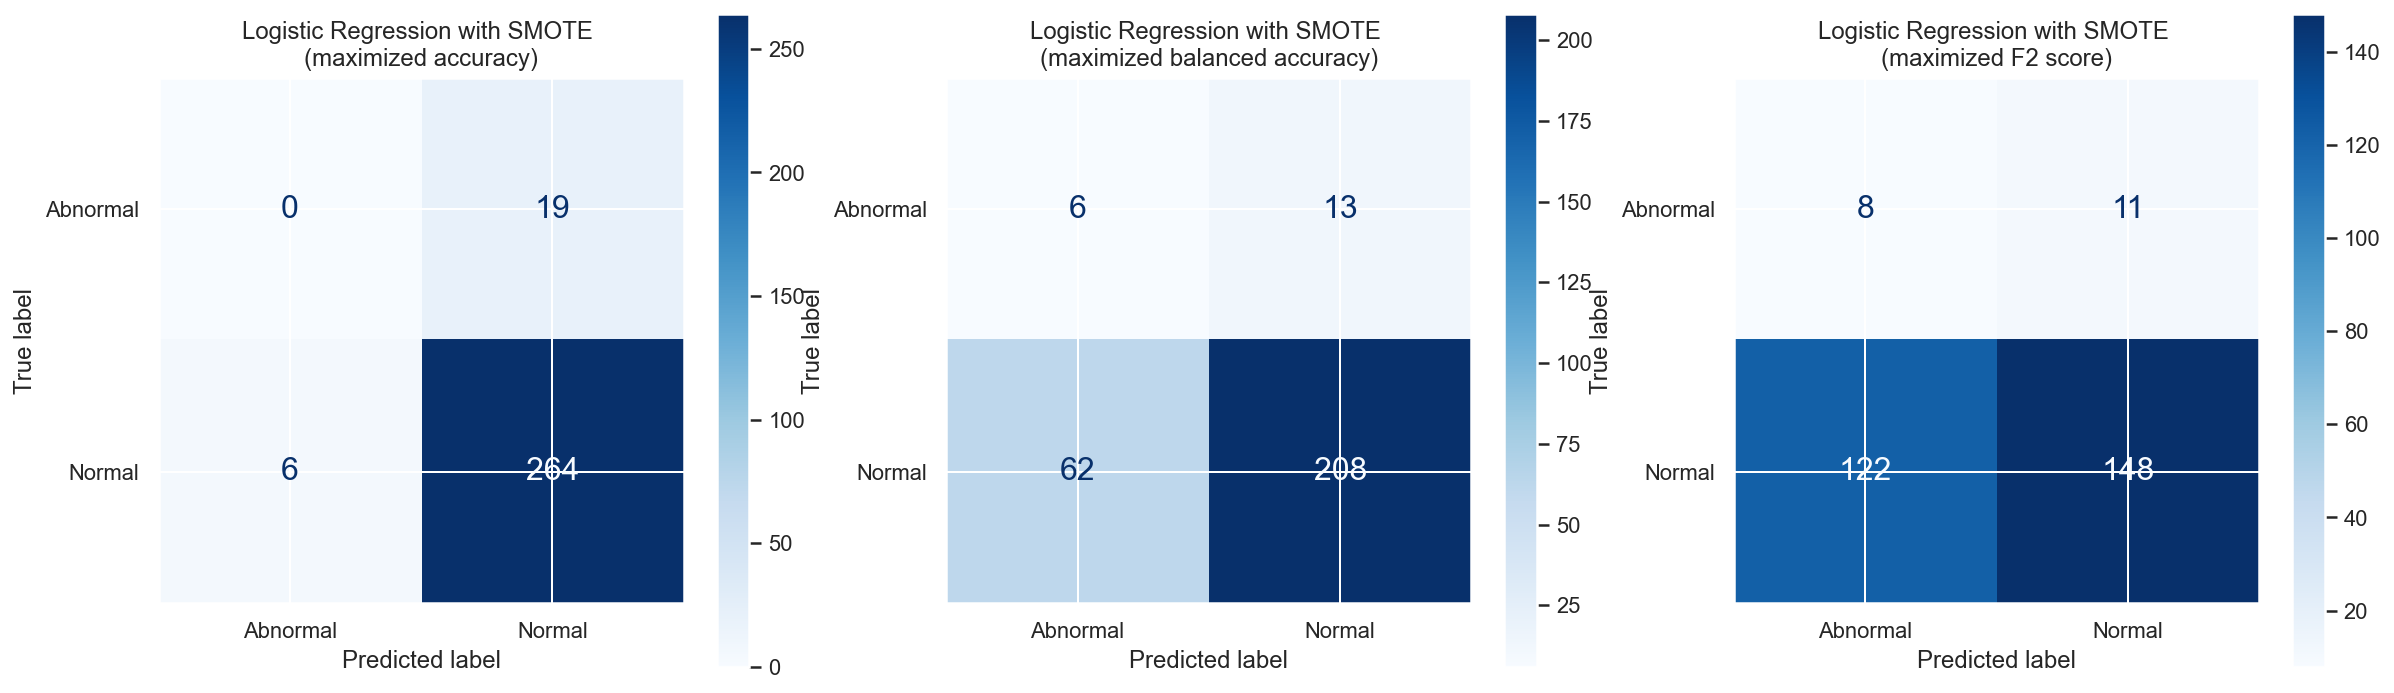

In [290]:
fig, ax = plt.subplots(ncols=3, figsize=(20,6))
plot_confusion_matrix(best_log_reg_sm_acc, X_sm_test, y_sm_test, cmap='Blues', ax=ax[0])
plot_confusion_matrix(best_log_reg_sm_bal_acc, X_sm_test, y_sm_test, cmap='Blues', ax=ax[1])
plot_confusion_matrix(best_log_reg_sm_fbeta, X_sm_test, y_sm_test, cmap='Blues', ax=ax[2])
ax[0].set_title('Logistic Regression with SMOTE \n(maximized accuracy)')
ax[1].set_title('Logistic Regression with SMOTE \n(maximized balanced accuracy)')
ax[2].set_title('Logistic Regression with SMOTE \n(maximized F2 score)')
for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)
plt.show()

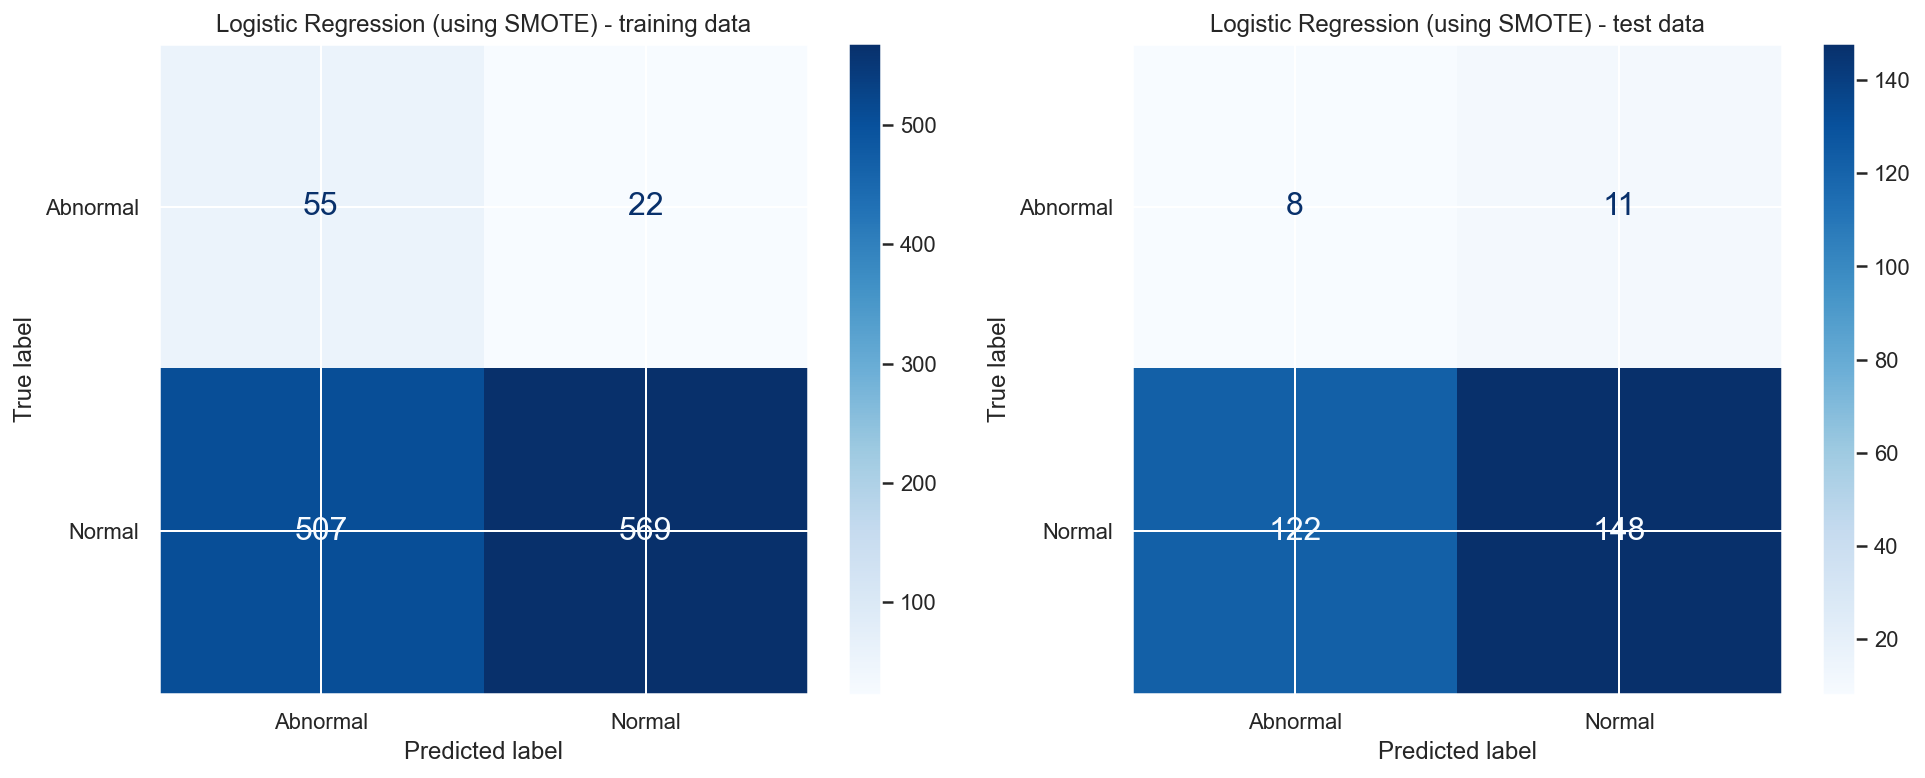

In [292]:
model = best_log_reg_sm_fbeta
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
plot_confusion_matrix(model, X_sm_train, y_sm_train, cmap='Blues', ax=ax[0])
plot_confusion_matrix(model, X_sm_test, y_sm_test, cmap='Blues', ax=ax[1])
ax[0].set_title('Logistic Regression (using SMOTE) - training data')
ax[1].set_title('Logistic Regression (using SMOTE) - test data')
for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)
plt.show()

### Results using SMOTE
The confusion matrices above show the results from using SMOTE to over-sample the training data to make the two classes ('Abnormal' and 'Normal') balanced for training the models. Different models were fine-tuned maximizing different scores as above. The model maximizing the F2 score predicts the highest number of 'Abnormal' instances correctly on the test data (8 out of 19), but this is lower than the model trained on the unbalanced data.

Using SMOTE does not seem to help in this case. It could be investigated further e.g. over-sampling the 'Abnormal' class to a lower degree (e.g. so it makes up 30% of the training data, not 50%).

### Conclusions
None of the models perform particularly well at predicting 'Abnormal' sales. The 'best' model is the one optimized on F2 score as this has relatively higher precision and recall scores for 'Abnormal'. Let's look at the model coefficients from this model to see if we can identify which features predict 'Abnormal' sales.  

The Precision-recall and ROC curves for this model are also shown below for completeness.

### Precision-recall and ROC curves

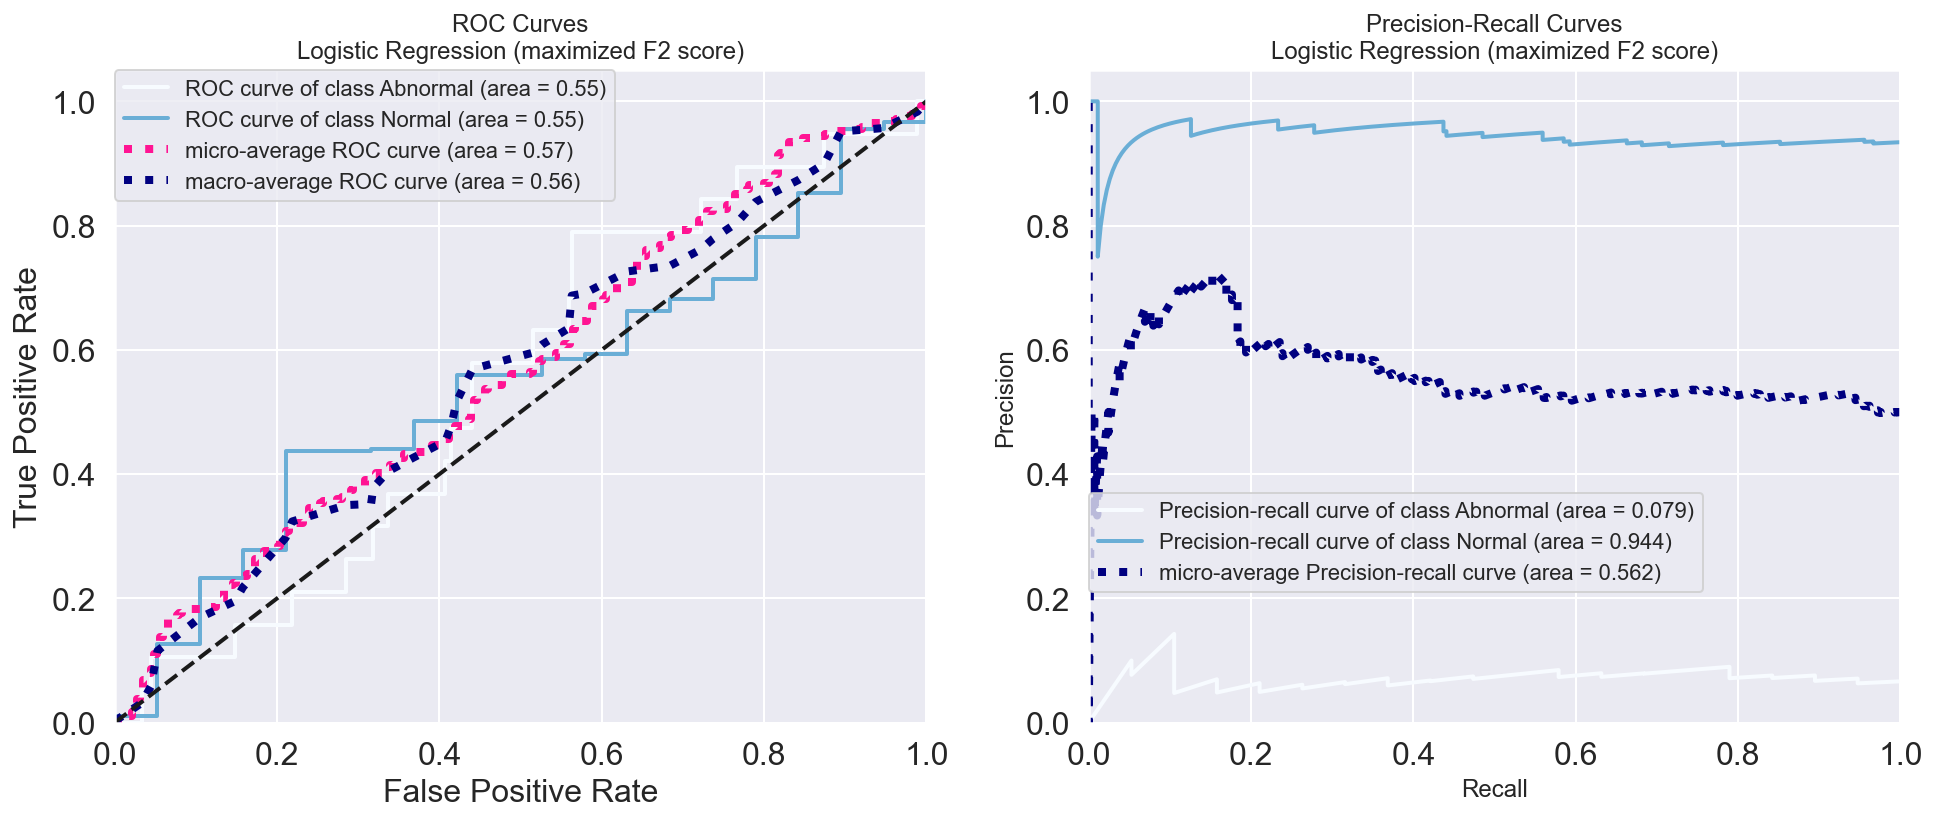

In [296]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
skplt.metrics.plot_roc(y_3_test, probs_log_reg_3, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[0])
skplt.metrics.plot_precision_recall(y_3_test, probs_log_reg_3, plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[1])
ax[0].set_title('ROC Curves\nLogistic Regression (maximized F2 score)')
ax[1].set_title('Precision-Recall Curves\nLogistic Regression (maximized F2 score)')
ax[0].legend(loc=(0,0.8))
ax[1].legend(loc=(0, 0.2))
plt.show()

### Model coefficients

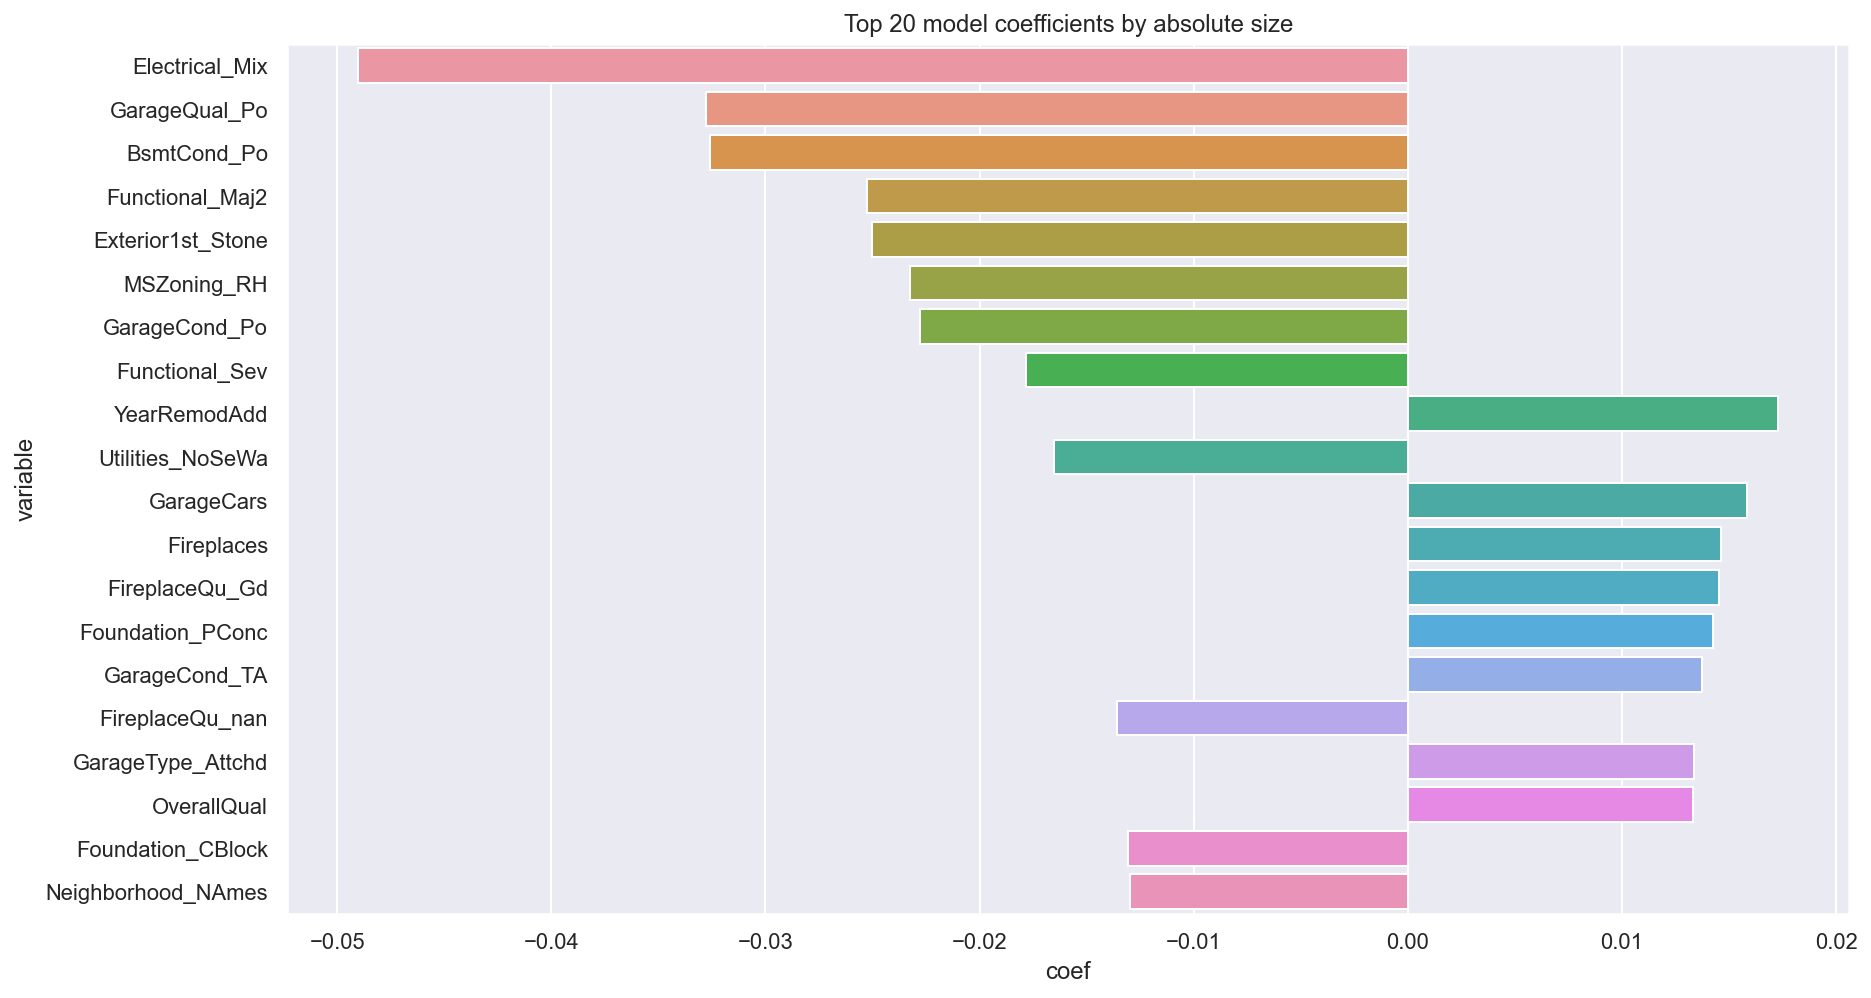

In [297]:
# plot model coefficients
model = best_log_reg_3
df_coef_3 = pd.DataFrame({'variable': X_3_train.columns, 
                          'coef': model.coef_[0], 
                          'coef_abs': np.abs(model.coef_[0])})

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_coef_3.sort_values('coef_abs', ascending=False).head(20), x='coef', y='variable')
plt.title('Top 20 model coefficients by absolute size')
plt.show()

### Predictive features of 'Abnormal' sales

The bar chart above shows the 20 model coefficients with the most impact on predicting 'Abnormal' sales. 

Features which make an abnormal sale more likely:
- *Electrical_Mix* - mixed electrical system 
- *GarageQual_Po* - poor garage quality
- *BsmtCond_Po* - poor condition of the basement (severe cracking, settling or wetness)
- *Functional_Sev* / *Functional_Maj2* - severely damaged / major deductions 2 home functionality 
- *Exterior1st_Stone* - stone exterior covering on a house
- *MSZoning_RH* - residential high density zoning
- *GarageCond_Po* - poor garage condition
- *Utilities_NoSeWa* - only utilities available Electricity and Gas
- *Foundation_CBlock* - a cinder block foundation
- *Neighborhood_NAmes* - neighborhood North Ames

Features which make an abnormal sale less likely:
- *YearRemodAdd* - a house which has been renovated more recently
- *GarageCars* - a larger garage
- *Foundation_PConc* - a poured concrete foundation
- *Fireplaces* - more fireplaces (this was also a strong predictor in part 2)
- *OverallQual* - a higher rating for the overall material and finish of the house

As discussed above, the classifiers struggled with the severe class imbalance. The final model selected was able to identify 'Abnormal' sales in 11 out of 19 cases on the test data, giving a recall score of 0.5789. However the false positive rate was very high giving a very low precision score of 0.0809. The features which had the most impact in this model listed above do make sense but given the low precision score this model should be used with caution. It could be used to identify a list of potential 'Abnormal' sales which would then need to be checked in another way to try and remove the false positives. The bank might have information on mortgages on houses and repayments on the mortgages which could be used to improve the precision.